<a href="https://colab.research.google.com/github/rosbuk/MakeDialogue/blob/main/%22%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%B8%D0%B0%D0%BB%D0%BE%D0%B3%D0%B0_%D1%81_chatGPT_%D0%A1%D0%BE%D0%B5%D0%B4%D0%B8%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B5%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%BA%D0%B8%D1%85_chatGPT_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание диалога. Суммаризация.

Для некоторых задач требуется возможность создания и накапливания диалога для дальнейшей его суммаризации и передачи в chatGPT вместе со следующим запросом пользователя, базой знаний и инструкцией. Вот, как можно это реализовать

In [ ]:
!pip install -U openai
!pip install -U langchain
!pip install -U langchain-openai
!pip install -U langchain-text-splitters
!pip install -U langchain-community
!pip install -U faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import re
import requests
import matplotlib.pyplot as plt
import textwrap
from textwrap import fill

import openai
from openai import OpenAI
import langchain_openai
import tiktoken
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter, CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.docstore.document import Document
import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)

In [ ]:
# использование секретного ключа в колабе
from google.colab import userdata
# Получение API ключа из пользовательских данных Colab и установка его как переменной среды
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1rihIt6rnBHfrv42C1ALtpoHoS2jIVseCg49aWqsOyk4')

In [ ]:
database[:1000]

'\ufeff#  Пусть соцсети работают на вас\r\n\r\n\r\n##  Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент\r\n\r\n\r\nPOSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран\r\n76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю\r\n15% увеличили количество клиентов уже в первые месяцы работы с сервисом\r\n55% отметили увеличение охвата постов и рост аудитории\r\n\r\n\r\n##  Создаём выдающиеся возможности для маркетинга в соцсетях\r\n\r\n\r\n1. Гибкие подписки: платите только за подключенные аккаунты, без лишних расходов и переплат\r\n2. Количество пользователей \r\n3. неограниченно: добавляйте коллег, клиентов или сотрудников для командной работы над проектами\r\n4. Количество проектов \r\n5. неограниченно: создавайте сколько угодно рабочих проектов и давайте к ним доступ членам команды\r\n6. Постинг 24/7: ведите сразу все нужные вам аккаунты на единой платформе\r\n7. Фоторедактор и библиотека с 2 млн. изображений: со

Дублируем текст заголовков без символов "#", чтобы тексты заголовков не пропали из чанков при использовании MarkdownHeaderTextSplitter  

In [ ]:
def duplicate_headers_without_hashes(text):
    """
    Дублирует заголовки в тексте, убирая из дубликатов хэши.

    Например:
    '# Заголовок' превращается в:
    '# Заголовок
    Заголовок'
    """

    # Вспомогательная функция, которая будет вызываться для каждого найденного совпадения в тексте
    def replacer(match):
        # match.group() вернет найденный заголовок с хэшами.
        # затем мы добавляем к нему перенос строки и ту же строку, но без хэшей
        return match.group() + "\n" + match.group().replace("#", "").strip()

    # re.sub ищет в тексте все заголовки, начинающиеся с 1 до 3 хэшей, и заменяет их
    # с помощью функции replacer
    result = re.sub(r'#{1,3} .+', replacer, text)

    return result

In [ ]:
database=duplicate_headers_without_hashes(database)

In [ ]:
# при необходимости предобработанную БЗ можно сохранить:
with open('Postoplan.txt', 'w') as f:
    f.write(database)

from google.colab import files
files.download('Postoplan.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
database[:10000]

'\ufeff#  Пусть соцсети работают на вас\r\nПусть соцсети работают на вас\n\r\n\r\n##  Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент\r\nСоцсети на автопилоте — создавайте, планируйте и продвигайте свой контент\n\r\n\r\nPOSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран\r\n76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю\r\n15% увеличили количество клиентов уже в первые месяцы работы с сервисом\r\n55% отметили увеличение охвата постов и рост аудитории\r\n\r\n\r\n##  Создаём выдающиеся возможности для маркетинга в соцсетях\r\nСоздаём выдающиеся возможности для маркетинга в соцсетях\n\r\n\r\n1. Гибкие подписки: платите только за подключенные аккаунты, без лишних расходов и переплат\r\n2. Количество пользователей \r\n3. неограниченно: добавляйте коллег, клиентов или сотрудников для командной работы над проектами\r\n4. Количество проектов \r\n5. неограниченно: создавайте сколько угодно рабочих проектов и давай

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Распределение длин чанков в токенах')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return fragments

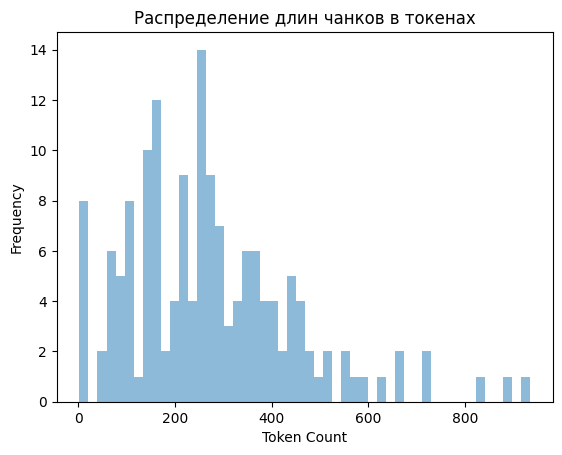

In [ ]:
source_chunks=split_text(database)

In [ ]:
source_chunks[1]

Document(metadata={'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент'}, page_content='Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент  \nPOSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран\n76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю\n15% увеличили количество клиентов уже в первые месяцы работы с сервисом\n55% отметили увеличение охвата постов и рост аудитории')

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()
# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)


In [ ]:
# Инструкция для GPT, которая будет подаваться в system
system= load_document_text('https://docs.google.com/document/d/1K1bQt7V-dVMIfwTK27-YicWrhgVTz8xmvtCrQLjC_d4')

In [ ]:
system

'\ufeffТы-нейро-консультант в компании POSTOPLAN, автоматизированной платформы маркетинга в соцсетях и мессенджерах. Далее тебе будет представлена следующая информация: саммаризированный предыдущий диалог с пользователем, актуальный вопрос пользователя, документы с информацией для ответа клиенту. Твоя задача - полно и точно ответить на вопрос пользователя по поводу компании POSTOPLAN, их продукте, ценах, тарифах.  Особенно аккуратно отвечай по цифрам - тарифам и  тому, что входит в каждый тариф. В своем ответе основывайся только на представленных тебе документах, не придумывай ничего “от себя”, однако пользователю об этих документах и их номерах не сообщай. \r\nЕсли пользователь представился (назвал свое имя), используй его имя при ответе. \r\nЕсли в кратком обзоре предыдущего диалога фигурирует имя пользователя, обязательно используй его в ответе, обращайся к пользователю по имени.\r\nТебе запрещено здороваться с пользователем'

In [ ]:
def answer_index(system, search_query, topic, search_index, verbose=0):
    # Поиск релевантных отрезков из базы знаний по вопросу пользователя
    docs = search_index.similarity_search(search_query, k=3)
    if verbose:
        print('\n ===========================================: ')

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose:
        print('message_content :\n ======================================== \n', message_content)

    client = OpenAI()
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос пользователя. Документы с информацией для ответа клиенту: {message_content}\n\n{topic}"}
    ]

    if verbose:
        print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0.1
    )
    answer = completion.choices[0].message.content
    return answer


Делаем функцию, которая будет суммаризировать диалог по мере его накапливания, и данную саммаризацию мы будем подавать модели, которая отвечает на вопрос клиента, чтобы модель учитывала контекст диалога.

In [ ]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-суммаризатор. Твоя задача - суммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Суммаризируй следующий диалог консультанта и пользователя, тебе запрещено удалять из суммаризации имя пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",     # используем gpt4 для более точной саммаризации
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

Далее следует основная функция, объединяющая все предыдущие. В нее мы подаем инструкцию, базу знаний, текущий вопрос клиента из чата, а также историю предыдущего диалога - при наличии.

In [ ]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " +summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ, используя только user_question для поиска в базе данных
    answer_text = answer_index(system, user_question, topic, db)

    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    return answer_text


Следующая функция запускает диалог с клиентом и останавливает его при вводе слова "stop".

In [ ]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', textwrap.fill(answer))

    return

In [ ]:
run_dialog(system, db)

Пользователь: привет, меня зовут Света, как ты можешь мне помочь?
Консультант: Здравствуй, Света! Я могу помочь тебе рассказать о сервисе POSTOPLAN -
автоматизированной платформе для работы с соцсетями. POSTOPLAN поможет
тебе экономить время на планировании и публикации контента, а также на
ответах на комментарии и вопросы подписчиков. У нас есть несколько
тарифов с разным функционалом, начиная от бесплатного тарифа и до
расширенных платных возможностей. Если у тебя возникнут дополнительные
вопросы или тебе понадобится помощь, можешь написать нам на
affiliate@postoplan.app.
Пользователь: какие у постоплан есть продукты?
****************************
Вот саммаризированный предыдущий диалог с пользователем: Консультант представился и рассказал пользователю Свете о сервисе POSTOPLAN - автоматизированной платформе для работы с соцсетями. Он объяснил, что сервис поможет экономить время на планировании и публикации контента, а также на ответах на комментарии и вопросы подписчиков. Консультант

In [ ]:
run_dialog(system, db)

Пользователь: Привет. Меня зовут Света. На какие вопросы ты можешь отвечать?
Консультант:  Привет, Света! Я могу отвечать на различные вопросы о компании POSTOPLAN, их продукте, ценах, тарифах, а также помогать с информацией о возможностях использования
 сервиса. Если у вас возникнут вопросы или вам понадобится помощь, не стесняйтесь обращаться по адресу affiliate@postoplan.app.
Пользователь: Какие продукты есть в компании постоплан?
****************************
Вот саммаризированный предыдущий диалог с пользователем: Консультант приветствует пользователя по имени Света и предлагает помощь в ответе на вопросы о компании POSTOPLAN, их продукте, ценах, тарифах, а также предлагает обратиться по адресу affiliate@postoplan.app в случае необходимости помощи.
****************************
Консультант:  Компания POSTOPLAN предлагает автоматизированную платформу маркетинга в соцсетях и мессенджерах. С ее помощью вы можете планировать и публиковать контент, управлять
 социальными сетями, а также 

# Нейро-продажник из 3 моделей gpt

In [ ]:
database = load_document_text('https://docs.google.com/document/d/199yEDg1EIlTImWjFR4FGRsqw70mjlP85jG8XduD6B24') # база знаний

In [ ]:
system_1 = load_document_text('https://docs.google.com/document/d/1xFYprEaF47_uiNHo4JQJevpVV6v5mG2v6mZXy93MZQA') # инструкция для первой модели

In [ ]:
system_2 = load_document_text('https://docs.google.com/document/d/12nLPgHv_HJMPnuGWlWVhOne9dH9-04cLSyusO0AVQ9o') # инструкция для второй модели

In [ ]:
system_3 = load_document_text('https://docs.google.com/document/d/1oY6-HEfL5NDvnvWaxrW_HqAs0tMX0ogpB8I1OXbbgx0') # инструкция для третьей модели

In [ ]:
# делим текст на чанки и создаем индексную базу
source_chunks = []
splitter = CharacterTextSplitter(separator="\n", chunk_size=1024, chunk_overlap=0)

for chunk in splitter.split_text(database):
    source_chunks.append(Document(page_content=chunk, metadata={"meta":"data"}))

# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)

In [ ]:
MODEL_GPT_3_5 = "gpt-3.5-turbo"
MODEL_GPT_4 = "gpt-4o"

def create_completion(model, system, content, temperature):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": content}
    ]
    client = OpenAI()
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0

    )
    return completion.choices[0].message.content

def create_completion_with_assistant(system, user_assist, assistant, user, temp=0, model='gpt-3.5-turbo'):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": user_assist},
        {'role':'assistant', 'content': assistant},
        {"role": "user", "content": f"{user}"}

    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    return answer

def first_model(system_1, db, topic, temperature=0):
    docs = db.similarity_search(topic, k=4)
    message_content = ' '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)])
    question_content = f"""Ты - менеджер по продажам в университете искусственного интеллекта. Ответь на вопрос пользователя на основании
    представленных документов и задай вопросы для выявления потребностей клиента.
    Документ с информацией для ответа клиенту: {message_content}\n\nВопрос клиента: \n{topic}"""
    return fill(create_completion(MODEL_GPT_3_5, system_1, question_content, 0))

def second_model(topic):
    user_assist = """Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие:
                не умею программировать, не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате:
                Потребности:  Возражения:
                То, что говорил клиент: 'Мне бы хотелось сменить профессию, я сейчас работаю медсестрой, но хочу переучиться и работать на удаленке, из дома.
                Вопрос - смогу ли я, ведь у меня нет соответствующего профильного образования, я никогда не программировала, математику совсем не помню'"""
    assistant = """Потребности: сменить деятельность, возможность работать удаленно Возражения: не умею программировать, не знаю математику"""
    user = f"""Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие: не умею программировать,
                не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате: Потребности:  Возражения:
                То, что говорил клиент: '{topic}'"""

    return create_completion_with_assistant(system_2, user_assist, assistant, user, temp=0, model=MODEL_GPT_3_5)

def third_model(system_3, db, topic, user_needs):
    docs = db.similarity_search(topic, k=4)
    message_content = ' '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)])
    input_text = f"""Ты - менеджер по продажам в университете искусственного интеллекта. Ответь на вопрос пользователя на основании представленных
    документов, но на сами документы не ссылайся, клиент ничего не должен о них знать. Документ с информацией для ответа клиенту: {message_content}\n\n
    если в отчете о выявленных потребностях имеется информация о потребностях клиента, то предложи клиенту подходящий тариф.
    Если такой информации нет - задавай вопросы для выявления потребностей.
    Отчет о выявленных потребностях клиента: {user_needs} \n\nТекущий вопрос: {topic}"""
    answer_text = create_completion(MODEL_GPT_3_5, system_3, input_text, 0)
    return fill(answer_text)


Проверяем, как срабатывает функция:

In [ ]:
user_assist = """Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие: не умею программировать,
                не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате: Потребности:  Возражения:
                То, что говорил клиент: 'Мне бы хотелось сменить профессию, я сейчас работаю медсестрой, но хочу переучиться и работать на удаленке, из дома.
                Вопрос - смогу ли я, ведь у меня нет соответствующего профильного образования, я никогда не программировала, математику совсем не помню'"""
assistant = """Потребности: сменить деятельность, возможность работать удаленно. Возражения: не умею программировать, не знаю математику. """

topic = """Мне бы хотелось стать программистом и уйти с действующей работы, но так как я работаю full time, у меня не будет хватать времени на учебу"""
user = f"""Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие: не умею программировать,
                не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате: Потребности:  Возражения:
                То, что говорил клиент: '{topic}'"""
ans = create_completion_with_assistant(system_2, user_assist, assistant, user, temp=0, model=MODEL_GPT_3_5)

In [ ]:
ans

'Потребности: сменить деятельность, развиваться в сфере IT. Возражения: нет времени.'

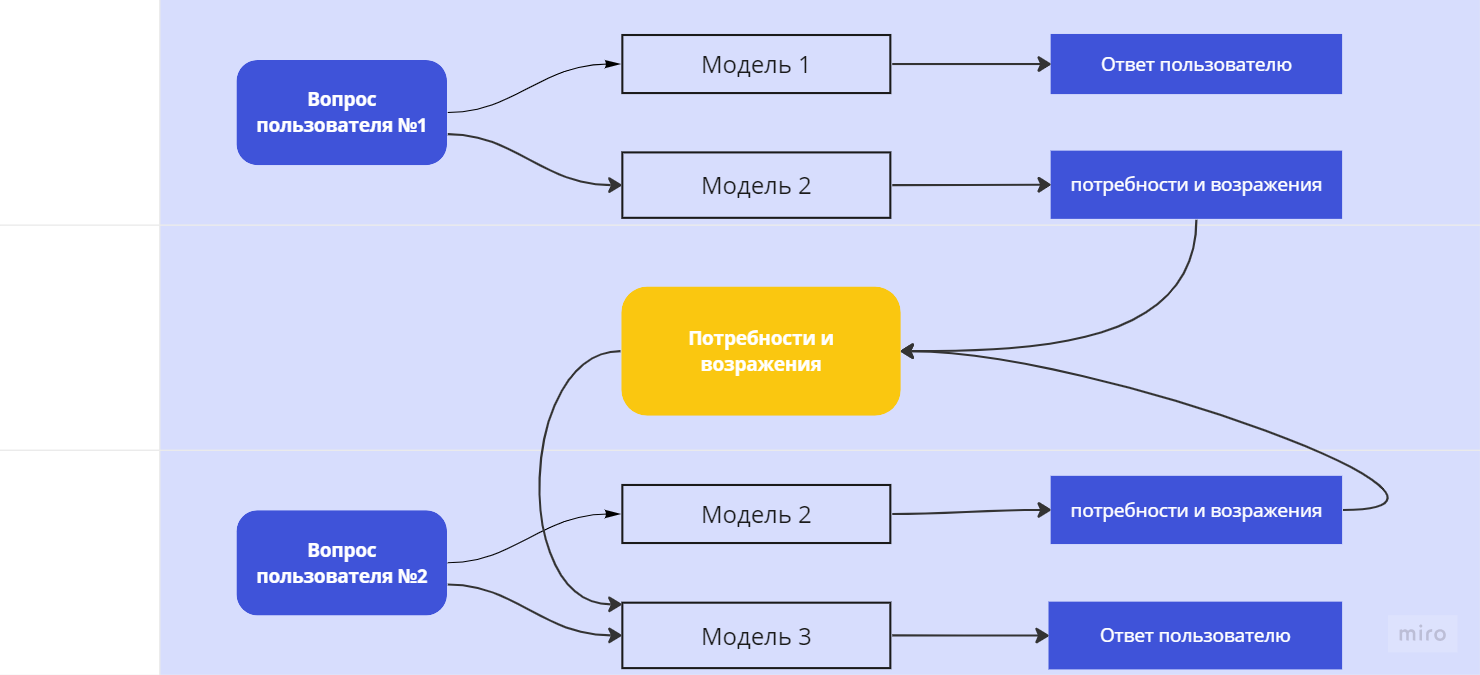

In [ ]:
def run_dialog():
    clients_needs = ""
    topic = input('Клиент: ')
    answer_1 = first_model(system_1, db, topic, temperature=0)
    answer_2 = second_model(topic)
    clients_needs += answer_2
    print('\nМенеджер: ', answer_1)
    print("------------------")
    print("ответ 2 модели:", answer_2)

    while True:
        topic = input('Клиент: ')
        if topic.lower() == 'stop':
            break
        answer_3 = third_model(system_3, db, topic, clients_needs)
        answer_2 = second_model(topic)
        clients_needs += answer_2
        print('\nМенеджер: ', answer_3)
        print("------------------")
        print("ответ 2 модели:", answer_2)
        print("------------------")
        print("Выявленные потребности и возражения", clients_needs)
        print("------------------")

    return


Попробуем работу продажника на модели gpt3.5

In [ ]:
run_dialog()

Клиент: заинтересовала тема нейронных сетей. Насколько человеку без профильного образования под силу с этим разобраться?

Менеджер:  Здравствуйте! Рад, что вас заинтересовала тема нейронных сетей. У нас
в Университете искусственного интеллекта (УИИ) есть курсы, которые
помогут вам разобраться с этой темой. Хотели бы вы узнать больше о
наших курсах и какие цели вы преследуете, изучая нейронные сети?
------------------
ответ 2 модели: Потребности: развиваться в сфере IT, увлекательное хобби Возражения: нет профильного образования
Клиент: смогу ли я в рамках прохождения вашего курса реализовать собственный проект? У меня есть классная идея, но мне нужна помощь с реализацией

Менеджер:  Конечно, вы сможете реализовать свой собственный проект в рамках
нашего курса. Мы предлагаем несколько тарифов, которые могут подойти
для ваших потребностей. Например, тариф "AI под ключ" предоставляет
полное сопровождение при создании проекта, включая поддержку куратора
на всех этапах работы, дополнительны

In [ ]:
run_dialog()

Клиент: Привет, меня зовут Света, хочу сменить профессию

Менеджер:  Привет, Света! Рада приветствовать тебя! Какая интересная цель -
сменить профессию! Расскажи мне, пожалуйста, что именно побудило тебя
задуматься о смене профессии? Что ты хотела бы делать в новой сфере
деятельности?
------------------
ответ 2 модели: Потребности: сменить деятельность
Клиент: хочу найти работу программистом и работать из дома

Менеджер:  Понимаю ваше желание сменить деятельность и найти работу программистом
с возможностью работать из дома. Наши курсы идеально подходят для
этого, так как они предоставляют все необходимые знания и навыки для
успешного трудоустройства в сфере AI.  Для ваших целей я бы
рекомендовал тариф "Основной". Он включает в себя:  - 32 занятия по
нейронным сетям - 40 недель поддержки куратора - Гарантию
трудоустройства - Реализацию AI проекта - 8 продвинутых занятий по
нейронным сетям - 25 бонусных занятий - Курс "Python для анализа
данных" - Курс "AI директор" - 10 часов индивидуал

Попробуем работу продажника на модели gpt4o

In [ ]:
def third_model(system_3, db, topic, user_needs):
    docs = db.similarity_search(topic, k=4)
    message_content = ' '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)])
    input_text = f"""Ты - менеджер по продажам в университете искусственного интеллекта. Ответь на вопрос пользователя на основании представленных
    документов, но на сами документы не ссылайся, клиент ничего не должен о них знать. Документ с информацией для ответа клиенту: {message_content}\n\n
    если в отчете о выявленных потребностях имеется информация о потребностях клиента, то предложи клиенту подходящий тариф.
    Если такой информации нет - задавай вопросы для выявления потребностей.
    Отчет о выявленных потребностях клиента: {user_needs} \n\nТекущий вопрос: {topic}"""
    answer_text = create_completion(MODEL_GPT_4, system_3, input_text, 0)
    return fill(answer_text)

In [ ]:
run_dialog()

Клиент: Привет. Меня зовут Света. Чем ты можешь мне помочь?

Менеджер:  Привет, Света! Рад приветствовать тебя! Я представляю Университет
искусственного интеллекта. Могу помочь тебе с выбором курсов по AI,
которые могут помочь тебе в твоей профессиональной деятельности.   Для
начала, хотелось бы узнать, какие цели ты преследуешь, обратившись к
нам? Хочешь ли ты трудоустроиться в сфере искусственного интеллекта,
создать свой собственный AI проект или у тебя есть другие планы и
желания? Расскажи мне, что для тебя важно в обучении AI.
------------------
ответ 2 модели: Потребности:  Возражения:  
Клиент: мне все интересно, что связано с ИИ. Чему вы меня можете обучить?

Менеджер:  Мы можем предложить вам обучение, которое охватывает широкий спектр
тем, связанных с искусственным интеллектом. В зависимости от
выбранного тарифа, вы сможете изучить:  1. **Основы нейронных сетей и
программирования**: Научитесь писать коды, создавать и применять
нейронные сети. 2. **Продвинутые темы**: Углублен